In [1]:
import tensorflow as tf
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind

%matplotlib inline

In [2]:
# set plot theme
sns.set_style('whitegrid')

## Loading data from tensorboard

In [3]:
def directorypath_generator(tensorboard_logdirectory='runs/mnist_sgd_vs_adam'):
    '''Assumes each experiment has a single events directory'''
    for directory in os.listdir(tensorboard_logdirectory):
        experiment_directory = os.path.join(tensorboard_logdirectory, directory)
        experiment_file = os.path.join(experiment_directory, os.listdir(experiment_directory)[0])
        yield directory, experiment_file

In [4]:
def process_tf_experiment(path_to_events_file):
    data = {}
    # get all possible values
    for event in tf.train.summary_iterator(path_to_events_file):
        for value in event.summary.value:
#             print(value)
            if value.tag in data:
                data[value.tag].append(value.simple_value)
            else:
                data[value.tag] = [value.simple_value]
    res = pd.DataFrame(data)
    res.index.name = 'epoch'
    return res

In [5]:
algos = ['Nest_SGD_smooth_0.96', 'Nest_SGD_step_.45_10',
         'Nest_SGD_step_.2_30', 'ADAM', 'AMSGrad']
def process_experiment_name(name, algos=algos):
    trial_num = int(name.split(']')[0][7:])
    lr = float(name.split('_')[-1][3:])
    
    # get model
    if 'lenet' in name:
        model = 'lenet'
    elif 'mlp_1024_1024' in name:
        model = 'mlp_1024_1024'
    elif 'mlp_1024' in name:
        model = 'mlp_1024'
    else:
        raise Exception('unknown model')
    
    # get training algo
    algo = None
    for a in algos:
        if a in name:
            algo = a
            break
    if algo is None:
        raise Exception('unknown training algo')
    return dict(trial_num=trial_num, lr=lr, model=model, algo=algo)

In [6]:
exp_configs, exp_res = [], []
for exp_name, exp_file in directorypath_generator():
    exp_configs.append(process_experiment_name(exp_name))
    exp_res.append(process_tf_experiment(exp_file))

## T-tests

In [7]:
min_train_err = list(map(lambda res: res['train_err'].min(), exp_res))
end_train_err = list(map(lambda res: res['train_err'].iloc[-1], exp_res))
min_val_err = list(map(lambda res: res['val_err'].min(), exp_res))
end_val_err = list(map(lambda res: res['val_err'].iloc[-1], exp_res))

In [8]:
df = pd.DataFrame([
    {**exp_configs[i], 
     'min_val_err':min_val_err[i], 
     'end_val_err':end_val_err[i],
     'min_train_err':min_train_err[i], 
     'end_train_err':end_train_err[i],
    }
    for i in range(len(exp_configs))])

In [9]:
df_lenet = df[df.model == 'lenet'].sort_values(by=['algo','trial_num'])
df_mlp_single = df[df.model == 'mlp_1024'].sort_values(by=['algo','trial_num'])
df_mlp_double = df[df.model == 'mlp_1024_1024'].sort_values(by=['algo','trial_num'])

In [10]:
def run_ttest(df, metric, algos):
    assert len(algos) == 2, 'only supports pairwise comparison of two algos'
    df_a = df[df['algo'] == algos[0]]
    df_b = df[df['algo'] == algos[1]]
    t_stat, p_val = ttest_ind(df_a[metric], df_b[metric])
    return p_val

In [11]:
models = ['lenet', 'mlp_1024', 'mlp_1024_1024']
# algos = ['Nest_SGD_smooth_0.96', 'ADAM', 'AMSGrad']
metrics = ['min_val_err', 'end_val_err', 'min_train_err', 'end_train_err']
sgd_name = 'Nest_SGD_smooth_0.96'
adam_name = 'ADAM'
amsgrad_name = 'AMSGrad'
res = []
p_label = lambda metric, comparison: 'p_{}_{}'.format(metric, comparison)
mean_label = lambda metric, algo: 'mean_{}_{}'.format(metric, algo)
for model in models:
    data = {'model':model}
    model_df = df[df['model'] == model]
    for metric in metrics:
        p_adam_vs_amsgrad = run_ttest(model_df, metric, [adam_name, amsgrad_name])
        p_sgd_vs_adam = run_ttest(model_df, metric, [sgd_name, adam_name])
        p_sgd_vs_amsgrad = run_ttest(model_df, metric, [sgd_name, amsgrad_name])
        data[p_label(metric, 'adam_vs_amsgrad')] = p_adam_vs_amsgrad
        data[p_label(metric, 'sgd_vs_adam')] = p_sgd_vs_adam
        data[p_label(metric, 'sgd_vs_amsgrad')] = p_sgd_vs_amsgrad
        for algo in algos:
            data[mean_label(metric, algo)] = model_df[df['algo'] == algo][metric].mean()
    res.append(data)

/home/luke/.conda/envs/ml/lib/python3.6/site-packages/ipykernel_launcher.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [12]:
results = pd.DataFrame(res).set_index('model', drop=True)

In [13]:
def get_sub_exp(df, exp):
    cols = list(filter(lambda name: exp in name, results.columns))
    return df[cols]

In [14]:
get_sub_exp(results, 'min_val_err').apply(np.vectorize('{:.4f}'.format))

,mean_min_val_err_ADAM,mean_min_val_err_AMSGrad,mean_min_val_err_Nest_SGD_smooth_0.96,mean_min_val_err_Nest_SGD_step_.2_30,mean_min_val_err_Nest_SGD_step_.45_10,p_min_val_err_adam_vs_amsgrad,p_min_val_err_sgd_vs_adam,p_min_val_err_sgd_vs_amsgrad
model,,,,,,,,
lenet,0.0084,0.0070,0.0081,0.0080,0.0077,0.0000,0.0446,0.0000
mlp_1024,0.0155,0.0158,0.0161,0.0150,0.0150,0.0000,0.0000,0.0000
mlp_1024_1024,0.0152,0.0167,0.0176,0.0166,0.0168,0.0000,0.0000,0.0000


## Graphs

In [15]:
base_metrics = ['train_err', 'train_loss', 'val_err', 'val_loss']
sgd_algos = ['Nest_SGD_smooth_0.96', 'Nest_SGD_step_.45_10', 
             'Nest_SGD_step_.2_30']
def get_metrics(algo):
    if algo in sgd_algos:
        return base_metrics + ['lr']
    else:
        return base_metrics
n_epochs = exp_res[0].shape[0]
n_trials = 30
# create nested dict structure (like JSON)
organized_data = {}
for model in models:
    organized_data[model] = {}
    for algo in algos:
        organized_data[model][algo] = {}
        for metric in get_metrics(algo):
            organized_data[model][algo][metric] = np.zeros((n_trials, n_epochs))

# populate dict of dicts with lists of lists
for i in range(len(exp_configs)):
    config = exp_configs[i]
    res = exp_res[i]
    algo = config['algo']
    model = config['model']
    trial = config['trial_num']
    metrics = get_metrics(algo)
    outer_dict = organized_data[model]
    inner_dict = outer_dict[algo]
    for metric in metrics:
        inner_dict[metric][trial, :] = res[metric]

# collapse inner lists to mean/std
summarized_data = {}
for model, outer_dict in organized_data.items():
    summarized_data[model] = {}
    for algo, inner_dict in outer_dict.items():
        summarized_data[model][algo] = {}
        metrics = get_metrics(algo)
        for metric in metrics:
            array = inner_dict[metric]
            summarized_data[model][algo]['mean_'+metric] = np.mean(array, axis=0)
            summarized_data[model][algo]['std_'+metric] = np.std(array, axis=0)

In [63]:
# drop non-smooth SGD decays
drop_algos = ['Nest_SGD_step_.45_10', 'Nest_SGD_step_.2_30']
summarized_data = {model:{algo:innermost_dict 
                          for algo, innermost_dict in inner_dict.items() 
                          if algo not in drop_algos}
                   for model, inner_dict in summarized_data.items()}

In [64]:
summarized_data

{'lenet': {'ADAM': {'mean_train_err': array([0.060415  , 0.01729333, 0.01315278, 0.01052222, 0.00941833,
          0.00818333, 0.00743889, 0.00682111, 0.00610889, 0.00599333,
          0.00552667, 0.00529056, 0.00500778, 0.00454   , 0.00443889,
          0.00428278, 0.00407389, 0.00370611, 0.00380444, 0.00375   ,
          0.00340444, 0.00325444, 0.00311389, 0.00324889, 0.00299167,
          0.00303167, 0.00290278, 0.00287389, 0.00276444, 0.00284278,
          0.00276   , 0.00241056, 0.002315  , 0.00251722, 0.00250778,
          0.00250889, 0.00224278, 0.00236111, 0.00236444, 0.00230056,
          0.00214   , 0.00233389, 0.00199833, 0.00204222, 0.00199722,
          0.00205722, 0.00208278, 0.00197056, 0.00193056, 0.00171722,
          0.001895  , 0.00193333, 0.00183722, 0.00178056, 0.00188556,
          0.00169611, 0.00181556, 0.00166944, 0.00169611, 0.00161556,
          0.00183611, 0.00181556, 0.00169667, 0.00158111, 0.00154167,
          0.00172111, 0.00157   , 0.00167111, 0.0015422

In [109]:
def create_err_graph(model, metric='val_err', metric_name='Test Error Rate', algos=None, 
                     summarized_data=summarized_data, 
                     line_alpha=1.0, fill_alpha=0.2,
                     ylim=(0,0.1), start_epoch=1, end_epoch=None, figsize=(6,6)):
    plt.figure(figsize=figsize, dpi=120)
    fig = plt.subplot()
    data = summarized_data[model]
    algos = algos or list(data.keys())
    for algo in algos:
        value = data[algo]['mean_'+metric]
        err = data[algo]['std_'+metric]
        x = np.arange(value.shape[0]) + 1
        value = value[start_epoch-1:end_epoch]
        err = err[start_epoch-1:end_epoch]
        x = x[start_epoch-1:end_epoch]
        fig.plot(x, value, alpha=line_alpha)
#         fig.fill_between(x, value+err, value-err, alpha=fill_alpha)
        fig.fill_between(x, value+2*err, value-2*err, alpha=fill_alpha)
        fig.set_ylim(ylim)
        legend_algos = list(map(lambda x: 'Momentum_SGD' if 'Nest' in x else x, algos))
        fig.legend(legend_algos)
        plt.xlabel('Epoch')
        plt.ylabel(metric_name)

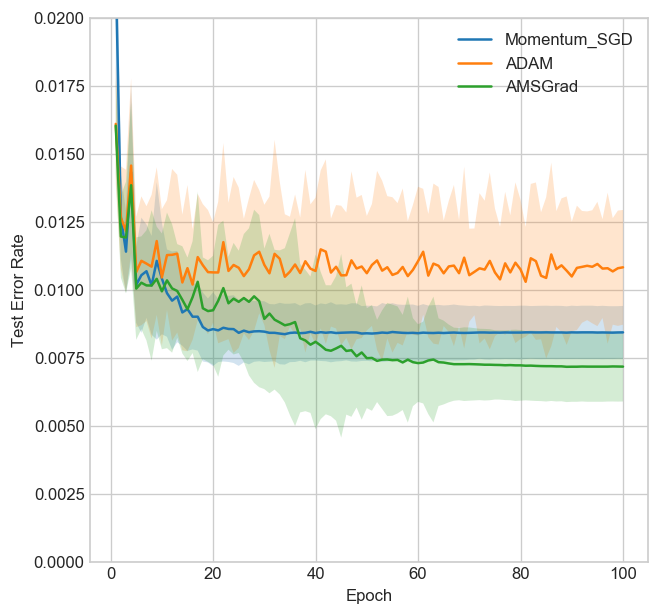

In [110]:
create_err_graph('lenet', ylim=(0.0,0.02))

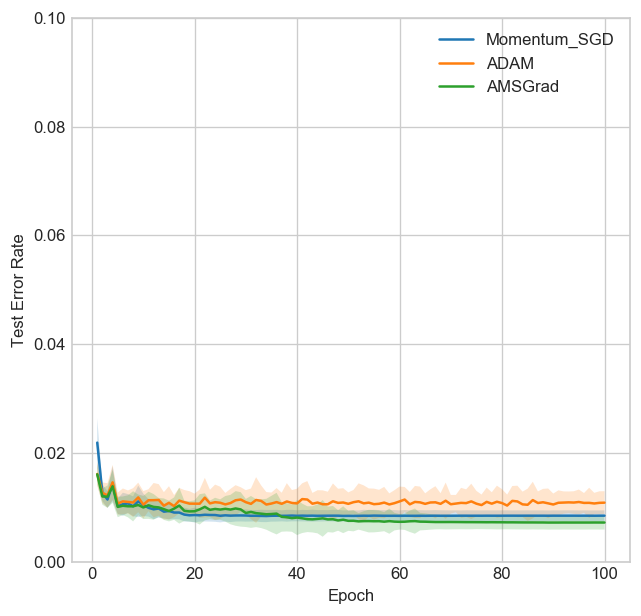

In [117]:
create_err_graph('lenet', ylim=(0.0,0.1))

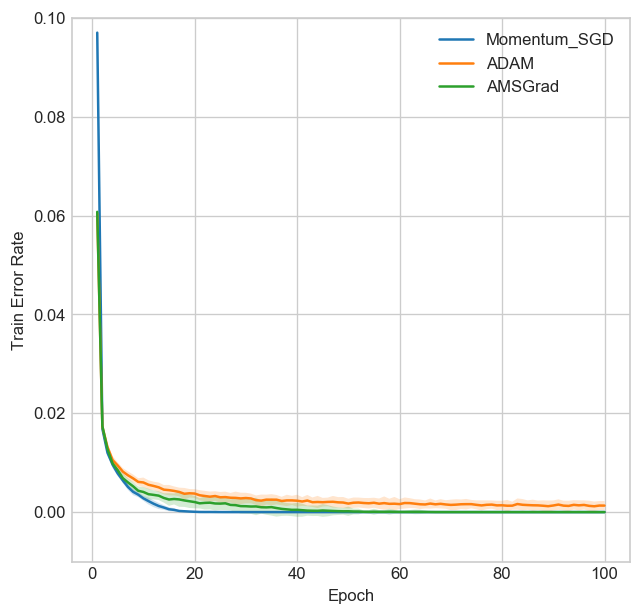

In [111]:
create_err_graph('lenet', 'train_err', metric_name='Train Error Rate', ylim=(-0.01,0.1))

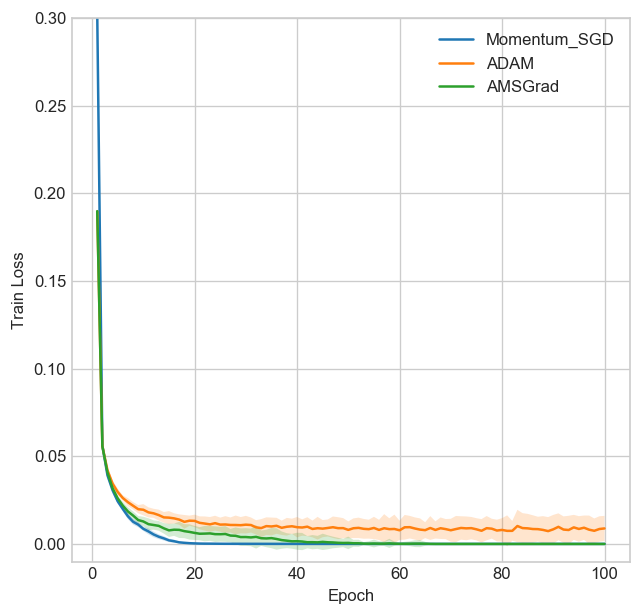

In [120]:
create_err_graph('lenet', 'train_loss', metric_name='Train Loss', ylim=(-0.01, 0.3))

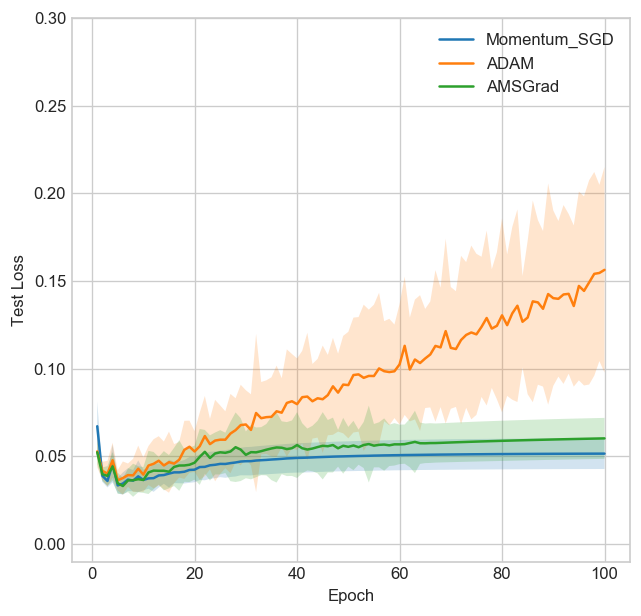

In [121]:
create_err_graph('lenet', 'val_loss', metric_name='Test Loss', ylim=(-0.01, 0.3))

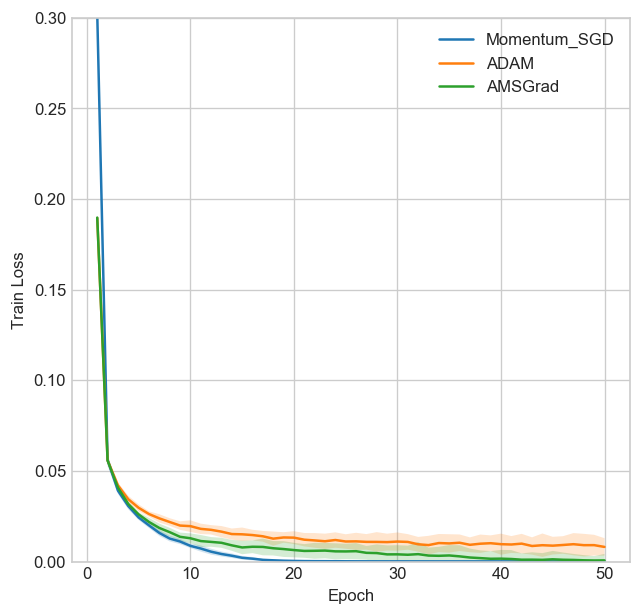

In [130]:
create_err_graph('lenet', 'train_loss', metric_name='Train Loss', ylim=(0, 0.3), end_epoch=50)

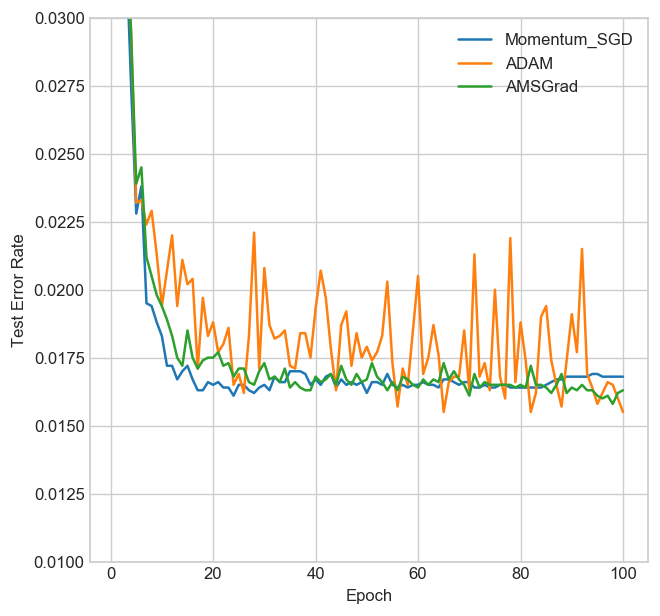

In [100]:
create_err_graph('mlp_1024', ylim=(0.01,0.03))

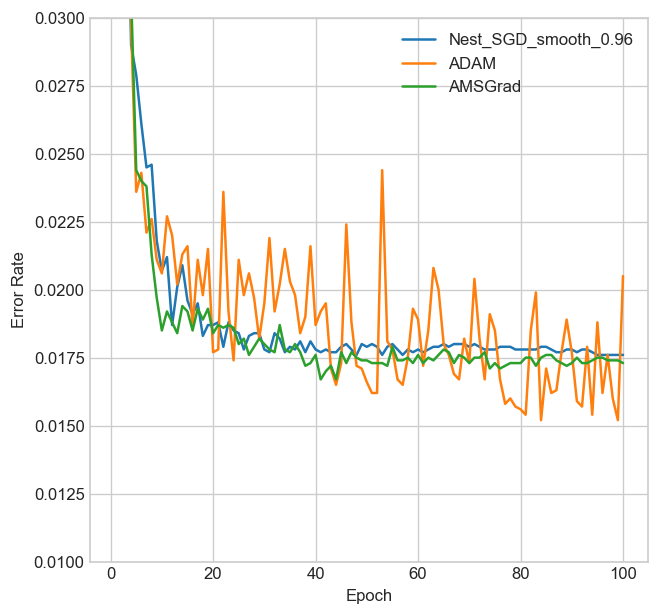

In [47]:
create_err_graph('mlp_1024_1024', ylim=(0.01,0.03))

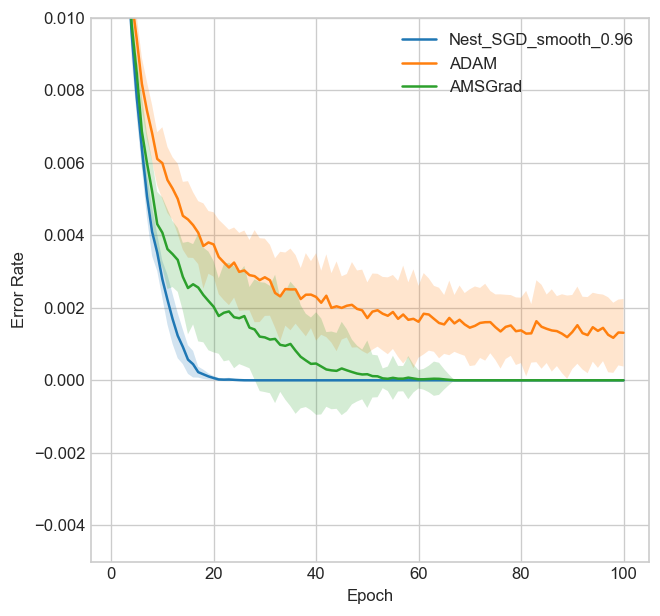

In [48]:
create_err_graph('lenet', metric='train_err', ylim=(-0.005,0.01))

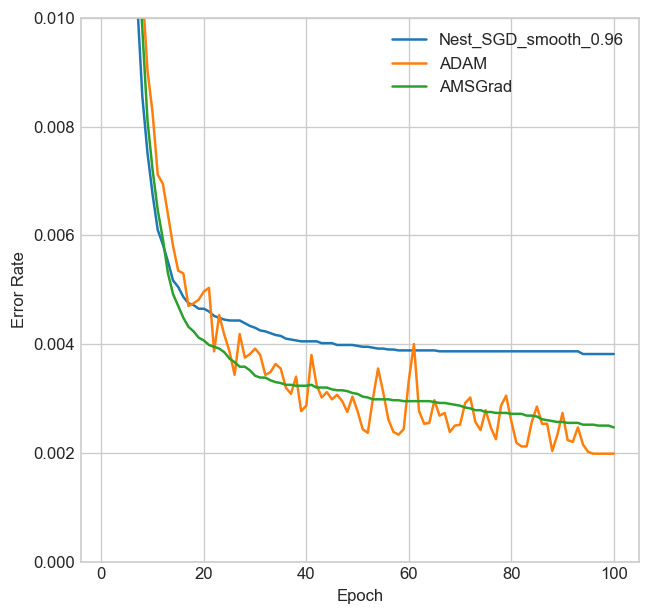

In [50]:
create_err_graph('mlp_1024', metric='train_err', ylim=(0.0,0.01))